In [1]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.io import read_image

import pandas as pd
import matplotlib.pyplot as plt

## Pre-processando os dados

In [2]:
import torchvision.transforms as T


# carregamento inicial sem normalização

tensor_train = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=True,
    download=True,
    transform=T.ToTensor()
)

tensor_test = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=False,
    download=True,
    transform=T.ToTensor()
)

# cálculo da média e do desvio padrão

imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs_mean = imgs.view(1, -1).mean(dim=1).item()
imgs_std = imgs.view(1, -1).std(dim=1).item()

# definição do transform

prep_transform = T.Compose(
    [
     T.ToTensor(),
     T.Normalize(mean=imgs_mean, std=imgs_std)
    ]
)

# carregamento normalizado

tensor_train = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=True,
    download=True,
    transform=prep_transform
)

tensor_test = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=False,
    download=True,
    transform=prep_transform
)

# Conhecendo o dataset

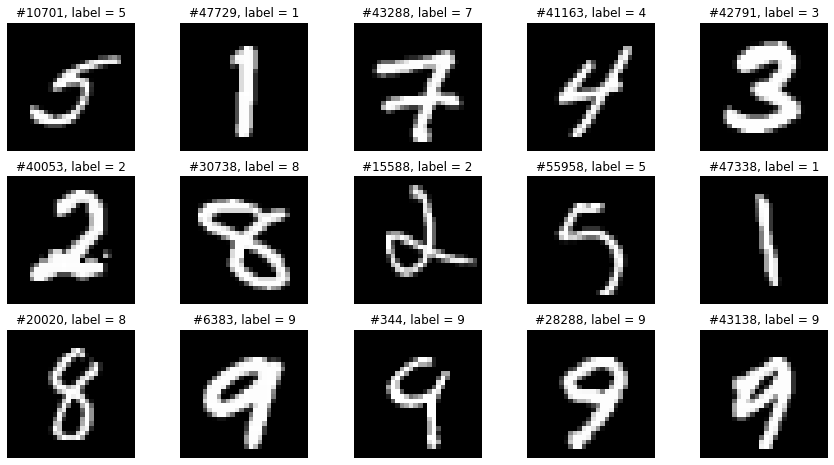

In [3]:
figure = plt.figure(figsize=(15, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tensor_train), size=(1,)).item()
    img, label = tensor_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'#{sample_idx}, label = {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Criando Dataloaders

In [4]:
from torch.utils.data import DataLoader

In [5]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

# Construindo multilayer Perceptron

In [6]:
from torch import nn

In [7]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10)
    )
  
  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [9]:
model = MLPClassifier().to(device)

## Escolhendo os hiperparâmetros de otimização

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
lossfunc = nn.CrossEntropyLoss()

In [11]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)


    pred = model(imgs)
    loss = lossfunc(pred, labels)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item para obter o float
    cumloss += loss.item()
  
  return cumloss / len(dataloader)

In [12]:
def validate(model, dataloader, lossfunc):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = lossfunc(pred, labels)
      cumloss += loss.item()
  
  return cumloss / len(dataloader)

In [ ]:
# treinamento

epochs = 1
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, lossfunc, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss}')
  test_loss = validate(model, test_loader, lossfunc)
  test_losses.append(test_loss)


tensor([  9.7692, -10.3227,   0.7929,   1.3021,  -2.8853,   5.3871,   1.7606,
         -0.9846,  -0.8174,  -2.5976], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 2.0677, -2.9832,  3.7542, -1.0661, -3.5584,  0.6656,  3.1096, -3.3674,
        -0.2906, -5.3343], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-6.0305,  2.1010,  0.2107,  2.5238, -1.2729,  0.5489, -6.5208,  5.3135,
         0.8340,  2.5202], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-3.0977, -6.6235, -3.7131, -4.1734,  6.4871,  2.1388, -2.8577,  2.9240,
         1.1983,  5.4917], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-3.8716, -4.9536, -4.9288,  1.8317,  3.4841,  4.0530, -8.8219,  7.4638,
         2.3380,  8.5497], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-5.0594, -0.8517,  1.6721, -2.1955, -1.7672, -1.3649, -1.1516, -4.3260,
         3.5853, -0.9627], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([  1.1339, -11.0556,   1.3842,  -5.8807,  -1.8029,   2.2939,   6.5079,

KeyboardInterrupt: ignored

# Avaliando o Resultado

In [13]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize='16')
  ax.set_xlabel('Iteration', fontsize='16')
  ax.set_ylabel('Loss', fontsize='16')
  ax.set_title('Loss vs iterations', fontsize='16')

IndexError: ignored

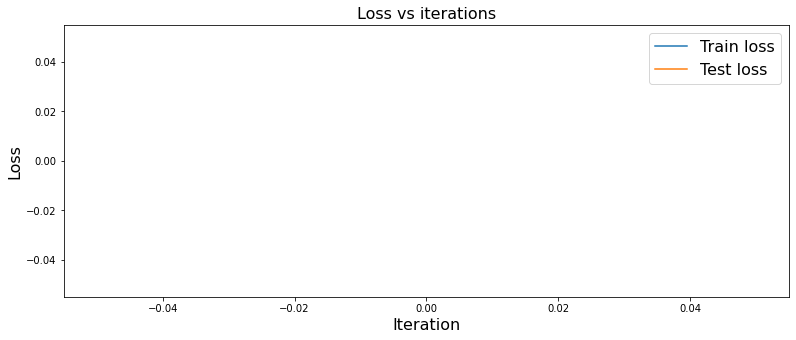

In [ ]:
losses = {'Train loss': train_losses, 'Test loss': test_losses}
plot_losses(losses)
print(test_losses[-1])

In [14]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [16]:
confusion_matrix = evaluate_accuracy(model, test_loader, ['0','1','2','3','4','5','6','7','8','9'])

Accuracy for class 0     is: 0.0 %
Accuracy for class 1     is: 0.0 %
Accuracy for class 2     is: 0.0 %
Accuracy for class 3     is: 85.6 %
Accuracy for class 4     is: 3.3 %
Accuracy for class 5     is: 0.0 %
Accuracy for class 6     is: 0.0 %
Accuracy for class 7     is: 0.0 %
Accuracy for class 8     is: 0.0 %
Accuracy for class 9     is: 0.0 %
Global acccuracy is 9.0


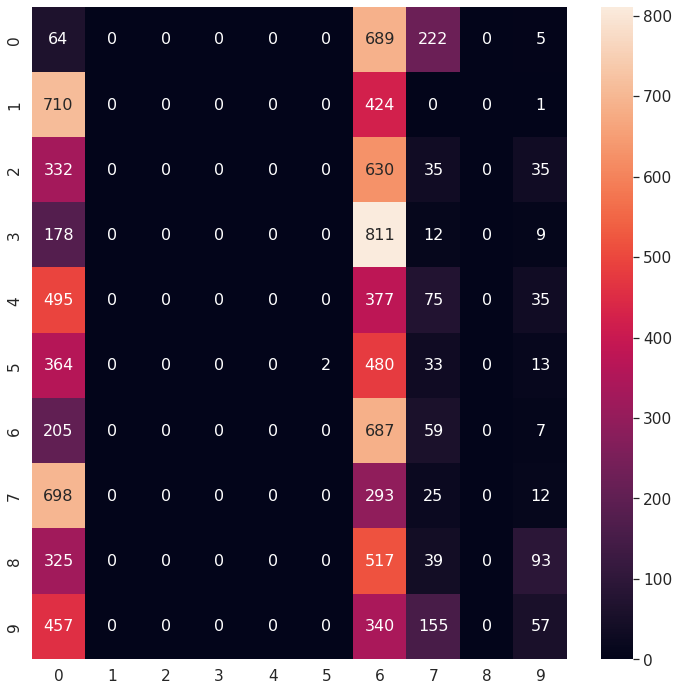

In [16]:
import seaborn as sn
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Construindo uma rede neural de convolução

In [17]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.convlayers = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(8, 16, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.linearlayers = nn.Sequential(
        nn.Linear(400, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
  
  def forward(self, x):
    # aprende as features
    x = self.convlayers(x)
    x = torch.flatten(x, 1)
    return self.linearlayers(x)


In [18]:
convmodel = ConvolutionalModel().to(device)

In [19]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr=0.001)
convlossfunc = nn.CrossEntropyLoss()

In [ ]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, convlossfunc, conv_optimizer)
  train_losses.append(train_loss)
  if t % 1 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss}')
  test_loss = validate(convmodel, test_loader, convlossfunc)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.297093853513315
Epoch: 1; Train Loss: 2.2721678460838954
Epoch: 2; Train Loss: 2.1990203923508047
Epoch: 3; Train Loss: 1.7299213131099367
Epoch: 4; Train Loss: 0.7569007773770452
Epoch: 5; Train Loss: 0.4693153575857057
Epoch: 6; Train Loss: 0.381375324195509
Epoch: 7; Train Loss: 0.3353028370103221
Epoch: 8; Train Loss: 0.3040389393263661
Epoch: 9; Train Loss: 0.279533997944582
Epoch: 10; Train Loss: 0.2589436254219841
Epoch: 11; Train Loss: 0.2410514571312775
Epoch: 12; Train Loss: 0.2248734008433468
Epoch: 13; Train Loss: 0.2106542580687542
Epoch: 14; Train Loss: 0.1977085483226695
Epoch: 15; Train Loss: 0.18563079226341075
Epoch: 16; Train Loss: 0.17526361389931586
Epoch: 17; Train Loss: 0.1657784238938234
Epoch: 18; Train Loss: 0.15711533984761122
Epoch: 19; Train Loss: 0.1490831991145288
Epoch: 20; Train Loss: 0.1418592339870073
Epoch: 21; Train Loss: 0.1356020877932085
Epoch: 22; Train Loss: 0.12926768918615034
Epoch: 23; Train Loss: 0.12404316538043304


0.08749545943941091


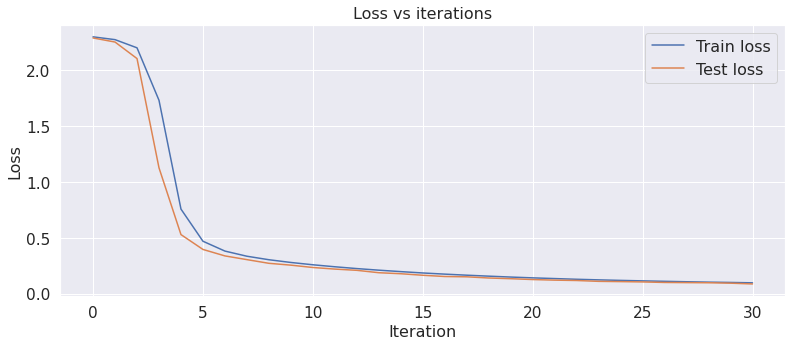

In [ ]:
convlosses = {'Train loss': train_losses, 'Test loss': test_losses}
plot_losses(convlosses)
print(test_losses[-1])

In [ ]:
confusion_matrix = evaluate_accuracy(convmodel, test_loader, ['0','1','2','3','4','5','6','7','8','9'])

Accuracy for class 0     is: 99.3 %
Accuracy for class 1     is: 98.9 %
Accuracy for class 2     is: 97.1 %
Accuracy for class 3     is: 97.7 %
Accuracy for class 4     is: 97.6 %
Accuracy for class 5     is: 96.6 %
Accuracy for class 6     is: 97.4 %
Accuracy for class 7     is: 96.7 %
Accuracy for class 8     is: 97.4 %
Accuracy for class 9     is: 95.0 %
Global acccuracy is 97.4


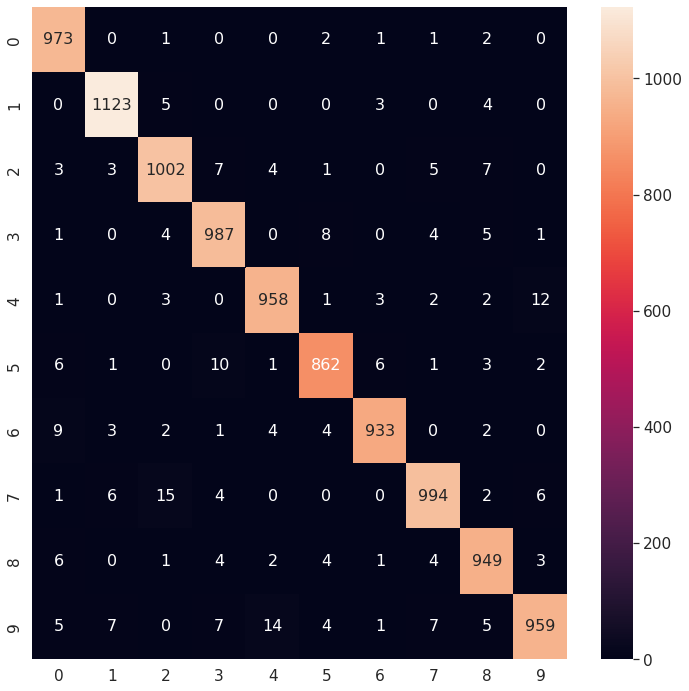

In [ ]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')

# Regressão Logística



In [20]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.layer1 = torch.nn.Linear(28*28, 10)
    self.softmax = torch.nn.Softmax(dim=1)
    self.flatten = nn.Flatten()
  
  def forward(self, x):
    v = self.flatten(x)
    logit = self.layer1(v)
    yhat = self.softmax(logit)
    return yhat

In [21]:
logistic_regression_model = LogisticRegression().to(device)
log_optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=0.01)
log_lossfunc = nn.CrossEntropyLoss()

In [ ]:
# treinamento

epochs = 1
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(logistic_regression_model, train_loader, log_lossfunc, log_optimizer)
  train_losses.append(train_loss)
  if t % 1 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss}')
  test_loss = validate(logistic_regression_model, test_loader, log_lossfunc)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 1.85341441961748


# Classificador de Mínimos Quadráticos

In [23]:
from sklearn.metrics import confusion_matrix

def ls_confusion_matrix(pred, y_test):
  cmat = confusion_matrix(pred, y_test)
  print(cmat)

In [27]:
class LeastSquaresRegressorTorch():
  def fit(self, X, y):
    self.θ = torch.matmul(torch.matmul(torch.linalg.pinv(torch.matmul(X.T, X)), X.T), y)
    self.b = torch.mean(y, dim=0) - torch.matmul(self.θ.T, torch.mean(X, dim=0))
    
  def predict(self, X):
    yhat = torch.matmul(X, self.θ) + self.b
    return yhat

X_train = torch.flatten(tensor_train.data, start_dim=1).float()
y_train = tensor_train.targets.float()

X_test = torch.flatten(tensor_test.data, start_dim=1).float()
y_test = tensor_test.targets

model_ls = LeastSquaresRegressorTorch()

model_ls.fit(X_train, y_train)
pred = model_ls.predict(X_test).round()
pred = torch.clamp(pred, min=0, max=9) 


print(pred.type(), pred.shape)
print(y_test.type(), y_test.shape)

#pred: torch.cuda.FloatTensor, torch.Size([64, 10])
#label: torch.cuda.LongTensor, torch.Size([64])

#melhor esquecer o loss!!!

#do jeito que tá aqui eu ja consigo calcular a acuracia, e somente esta
#é pedida no trabalho!

#loss = nn.CrossEntropyLoss()
#loss = nn.CrossEntropyLoss(pred, y_test)

#print(loss.item())

ls_confusion_matrix(pred, y_test)


def my_accuracy_score(yhat, y):
  success = 0
  for i in range(len(y)):
    if yhat[i] == y[i]:
      success += 1
  acc = success / len(y)
  return acc

print(my_accuracy_score(pred, y_test))

print(pred[:10], y_test[:10])
print(max(pred), max(y_test))

torch.FloatTensor torch.Size([10000])
torch.LongTensor torch.Size([10000])
[[281   8  39   7   0   1   1   0   0   0]
 [345 392 108  49   3   8   9   3   4   2]
 [209 438 231 165  17  68  39  19   4   6]
 [ 74 180 283 295  79 151  76  40  31  17]
 [ 42  63 228 261 204 193 161  82  84  32]
 [ 21  40 102 132 302 234 226 180 152  61]
 [  4   8  27  61 207 140 200 214 230 148]
 [  4   5  10  20 116  53 151 191 206 245]
 [  0   1   1  14  38  25  66 161 149 252]
 [  0   0   3   6  16  19  29 138 114 246]]
0.2423
tensor([6., 2., 1., 1., 3., 1., 6., 5., 4., 9.]) tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
tensor(9.) tensor(9)


In [ ]:
LeastSquares_model = LeastSquaresRegressorTorch().to(device)
ls_lossfunc = nn.CrossEntropyLoss()

In [ ]:
train_leastsquare(LeastSquares_model, tensor_train, tensor_test, ls_lossfunc)

tensor([5.8639, 2.1536, 1.0245,  ..., 8.7087, 6.1273, 7.0746])


IndexError: ignored

In [ ]:
X = torch.flatten(tensor_train.data, start_dim=1).float()
y = tensor_train.targets.float()

print(X.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [ ]:
θ = torch.matmul(torch.matmul(torch.linalg.pinv(torch.matmul(X.T, X)), X.T), y)
θ

In [ ]:
b = torch.mean(y, dim=0) - torch.matmul(θ.T, torch.mean(X, dim=0))
b

tensor(0.1598)